# Wordle Guesser

[Wordle](https://www.powerlanguage.co.uk/wordle/) is a popular word guessing game in which the player has six attempts at identifying a hidden 5-letter word. After each guess, the player receives color-coded feedback on each of the five letters of the guessed word: (1) a green letter indicates that this letter occurs in the hidden word at this position, (2) a yellow letter indicates that this letter occurs in the hidden word at a different position, (3) a gray letter doesn't appear in the hidden word.

In this notebook, I'm developing a way to make suggestions for the next guess based on the previous guesses (and the corresponding feedback from Wordle).

[1. Load possible words and list of letters ordered by frequency](#load)<br>
[2. Getting feedback on a guess](#get_feedback)<br>
[3. Determine remaining possible words](#remaining_words)<br>
[4. Choosing the first word](#first_word)<br>
[5. Algorithms to make the next guess](#algos)<br>
[5.1. Randomly choosing from remaining possible words](#algos_random)<br>
[5.2. Choose from remaining words by score](#algo_score)<br>

In [1]:
import numpy as np
import pandas as pd
import re
import random
import matplotlib.pyplot as plt

# 1. Load possible words and list of letters ordered by frequency <a id = 'load'>

In the following, I'm loading a list of possible words that are used in Wordle, as well as a list of letters sorted by how frequently they occur in the English language.

In [2]:
## List of possible words from FiveThirtyEight: 
# https://fivethirtyeight.com/features/when-the-riddler-met-wordle/

# Guessable words
# https://docs.google.com/spreadsheets/d/1KR5lsyI60J1Ek6YgJRU2hKsk4iAOWvlPLUWjAZ6m8sg/edit#gid=0
# all_words = pd.read_csv('https://docs.google.com/spreadsheets/d/1KR5lsyI60J1Ek6YgJRU2hKsk4iAOWvlPLUWjAZ6m8sg/gviz/tq?tqx=out:csv&sheet=Sheet1', header=None)[0]

# Mystery words
# https://docs.google.com/spreadsheets/d/1-M0RIVVZqbeh0mZacdAsJyBrLuEmhKUhNaVAI-7pr2Y/edit#gid=0
all_words = pd.read_csv('https://docs.google.com/spreadsheets/d/1-M0RIVVZqbeh0mZacdAsJyBrLuEmhKUhNaVAI-7pr2Y/gviz/tq?tqx=out:csv&sheet=Sheet1', header=None)[0]

# from https://www3.nd.edu/~busiforc/handouts/cryptography/letterfrequencies.html
#letters_ordered = ['e','t','a','i','n','o','s','h','r','d','l','u','c','m','f','w','y','g','p','b','v','k','q','j','x','z']
#letters_ordered = ['e','a','r','i','o','t','n','s','l','c','u','d','p','m','h','g','b','f','y','w','k','v','x','z','j','q']
letter_freq = {'e': 56.88, 'a': 43.31, 'r': 38.64, 'i': 38.45, 'o': 36.51, 't': 35.43, 'n': 33.92, 's': 29.23, 'l': 27.98, 'c': 23.13, 'u': 18.51, 'd': 17.25, 'p': 16.14, 'm': 15.36, 'h': 15.31, 'g': 12.59, 'b': 10.56, 'f': 9.24, 'y': 9.06, 'w': 6.57, 'k': 5.61, 'v': 5.13, 'x': 1.48, 'z': 1.39, 'j': 1.00, 'q': 1.00}


# 2. Getting feedback on a guess <a id='get_feedback'>

Before we start coming up with ways of guessing, we want to have a way of quickly obtaining feedback for a guess (given a hidden word). The following function returns it as a 5-character string.

In [3]:
def evaluate_guess(guess_str, hidden_str):
    """
    evaluate_guess returns character-wise feedback for a guess (g = green, x = gray, y = yellow)

    :guess_str: 5-character string with guessed word
    :hidden_str: actual hidden word to which guess is compared
    :return: feedback encoded with characters g, y, x
    """     
    res_str = '' # Initialize result string
    
    for char_id in np.arange(5):
        
        this_char_res = 'x' # Start by assuming that this letter can be excluded
        
        # If current character is anywhere in the hidden string, change result to "yellow"
        if guess_str[char_id] in hidden_str:
            this_char_res = 'y'
            
            # If current character is furthermore at the same position of the hidden word, change result to "green"
            if guess_str[char_id] == hidden_str[char_id]:
                this_char_res = 'g'
                
        res_str += this_char_res
        
    return res_str

Let's try: assuming the hidden word is `paper`, what feedback would the word `apple` prompt?

In [4]:
evaluate_guess(guess_str = 'apple', hidden_str = 'paper')

'yygxy'

# 3. Determine remaining possible words <a id='remaining_words'>

The next step is to try to come up with a suggestion for a guess which incorporates the knowledge we already have. Let's look at an example:
<br><br>
<img src="wordle_ex1.png" width=200>
<br><br>
After this first guess, we already know that 
<ul>
    <li>the hidden word contains both `r` and `t` (but not in the positions in which they appear in the word `aorta`)</li>
    <li>the second letter in the hidden word is `o`</li>
    <li>the letter `a` is not contained in the hidden word</li>
</ul>        
Let's store the information we have in two lists, one for guesses and one for responses:

In [5]:
prior_guesses = ['aorta']
prior_res     = ['xgyyx']

We can now apply the knowledge we have about the hidden word to systematically exclude all words from the list of possible hidden words `all_words` that don't match the feedback on the past guesses. First we reformat the information a pandas DataFrame (which makes handling the information easier when there are more guesses):

In [6]:
# Table with known information about each letter and the response from prior guesses
know = pd.DataFrame({ 'letter': list(''.join(prior_guesses)),
                      'response': list(''.join(prior_res)),
                      'position': list(np.arange(1,6)) * len(prior_guesses)
                     })  
know

,letter,response,position
0,a,x,1
1,o,g,2
2,r,y,3
3,t,y,4
4,a,x,5


### Step 1: Exclude words that contain excluded letters

We can remove all words from the list of possible remaining words (which will be in `rm`) that contain one of the letters that weren't "yellow" or "green" previously:

In [7]:
# Excluded letters (excluded letters don't counted if they also show up as green somewhere)
excluded_letters = [l for l in list(know[know['response']=='x']['letter'].unique()) if l not in list(know[know['response']=='g']['letter'].unique())]
excluded_letters

['a']

In [8]:
# Only words that don't contain excluded letters
rm = [w for w in all_words if not any(l in w for l in excluded_letters)]

In [9]:
print('Number of all possible words: ', len(all_words))
print('Number of remaining words: ', len(rm))

Number of all possible words:  2315
Number of remaining words:  1406


This already narrows down the number of possible words by 40%.

### Step 2: Exclude words that don't contain all "yellow" letters

In a next step, we can remove all words from `rm` that don't contain all letters that were at some point "yellow". All "yellow" letters must be incuded in the hidden word.

In [10]:
# Letters that were previously marked as yellow
yellow_letters = list(know[know['response']=='y']['letter'].unique())
yellow_letters

['r', 't']

In [11]:
# Only words that contain all yellow letters
rm = [w for w in rm if (yellow_letters == []) | all(l in w for l in yellow_letters)]

In [12]:
print('Number of remaining words: ', len(rm))

Number of remaining words:  136


Now we're already down to 136 words! This is still too much for guessing randomly (since we only have 6 attempts in total) but it's a great improvement.

### Step 3: Exclude words that don't have the "green" letters in the same places

The green letters are an important piece of information: we can remove all words from our list that don't have those letters in the exact same positions. First we're 

In [13]:
## Only words that have green letters in the right place
# positions with known letter
green_pos = know[know['response']=='g'].groupby('position', as_index=False).max()[['position','letter']]

# For each known position, filter only words that have the right letter in that position
for p, l in green_pos.itertuples(index=False):
    rm = [w for w in rm if w[p-1] == l] 

In [14]:
print('Number of remaining words: ', len(rm))
print(rm)

Number of remaining words:  17
['court', 'forte', 'forth', 'forty', 'motor', 'north', 'robot', 'roost', 'rotor', 'route', 'torch', 'torso', 'torus', 'tower', 'voter', 'worst', 'worth']


That brings us down to those last 17 words.

### Step 4: Exclude words that have a letter in a place where it was previously "yellow"

In the list above, one of the remaining words is `forte` but we already know that `r` cannot be in the third position and `t` cannot be in forth position because when we previously tried these letters in the same positions (in the word `aorta`), they were marked as yellow, not green. We can therefore in a last step exclude all words that have a letter in a position where is was previously marked as "yellow".

In [15]:
## Only words that don't have yellow letters in the same place as previously
# positions with yellow letter
yellow_pos = know[know['response']=='y'].groupby(['position','letter'], as_index=False).max()[['position','letter']]

# For each known position, filter only words that don't have the yellow letter in that position
for p, l in yellow_pos.itertuples(index=False):
    rm = [w for w in rm if w[p-1] != l] 

In [16]:
print('Number of remaining words: ', len(rm))

Number of remaining words:  7


### Step 5: Exclude previously tried words

Finally, we need to exclude previously tried words (in this case the word `aorta` was already excluded in the first step though because it contains `a`).

In [17]:
# Exclude words that were alrady tried
rm = [w for w in rm if w not in prior_guesses]

In [18]:
print('Number of remaining words: ', len(rm))

Number of remaining words:  7


### Remaining words

In [19]:
rm

['court', 'motor', 'robot', 'roost', 'rotor', 'tower', 'voter']

We are left with a list of only 7 possible words that are consistent with the information we got back from just this first guess (although the first guess was unusually helpful).

The following function combines the 5 steps and returns a DataFrame which in addition to the words themselves contains the number of distinct letters in them.

In [20]:
def remaining_words(prior_guesses, prior_res):
    """
    remaining_words returns a list of possible remaining words that are consistent with the results (feedback)
    returned by wordle for any previous guesses.

    :prior_guesses: list of 5-character strings representing previous guesses
    :prior_res: list of feedback strings for previous guesses (in the same order as prior_guesses)
    :return: list of remaining words
    """     
    # Table with known information about each letter and the response from prior guesses
    know = pd.DataFrame({ 'letter': list(''.join(prior_guesses)),
                          'response': list(''.join(prior_res)),
                          'position': list(np.arange(1,6)) * len(prior_guesses)
                         })  
    
    # Excluded and yellow letters (excluded letters not counted if they also show up as green somewhere)
    excluded_letters = [l for l in list(know[know['response']=='x']['letter'].unique()) if l not in list(know[know['response']=='g']['letter'].unique())]
    yellow_letters = list(know[know['response']=='y']['letter'].unique())
    
    # Only words that don't contain excluded letters
    rm = [w for w in all_words if not any(l in w for l in excluded_letters)]
    
    # Only words that contain all yellow letters
    rm = [w for w in rm if (yellow_letters == []) | all(l in w for l in yellow_letters)]
    
    ## Only words that have green letters in the right place
    # positions with known letter
    green_pos = know[know['response']=='g'].groupby('position', as_index=False).max()[['position','letter']]

    # For each known position, filter only words that have the right letter in that position
    for p, l in green_pos.itertuples(index=False):
        rm = [w for w in rm if w[p-1] == l]    
        
    ## Only words that don't have yellow letters in the same place as previously
    # positions with yellow letter
    yellow_pos = know[know['response']=='y'].groupby(['position','letter'], as_index=False).max()[['position','letter']]

    # For each known position, filter only words that don't have the yellow letter in that position
    for p, l in yellow_pos.itertuples(index=False):
        rm = [w for w in rm if w[p-1] != l]         
        
    # Exclude words that were alrady tried
    rm = [w for w in rm if w not in prior_guesses]
    
    # Add word score and number of unique letters and return as randomized dataframe
    rm = pd.DataFrame({'word': rm})
    rm['unique_letters'] = rm['word'].map(lambda x: len(set(x)))
    rm = rm.sample(frac = 1.)
        
    return rm

In [21]:
remaining_words(prior_guesses = ['aorta'], 
                prior_res     = ['xgyyx'])

,word,unique_letters
1,motor,4
3,roost,4
0,court,5
6,voter,5
2,robot,4
4,rotor,3
5,tower,5


# 4. Choosing the first word <a id='first_word'>

The first guess cannot rely on any feedback and therefore can be the same in each game. It has to be a word from the list of all words and we want to choose one that has 5 different letters so as to maximize the letters that can be excluded after the first try, or that could come back yellow.

In [22]:
best_starts = remaining_words([], [])
best_starts = best_starts.loc[best_starts['unique_letters']==5]
len(best_starts)

1566

There are still 1566 words to choose from, so we need some kind of way to prioritize them. Since we're hoping to either catch a green or yellow letter in the first try, we want to try letters that occur frequently in English words. We loaded a dictionary of words and their respective frequencies back [section 1](#load).

We can use these to assign a score to each word which is the sum of the frequencies for its letters:

In [23]:
def word_score(word):
    """
    word_score calculates a score based on letter frequencies. High score indicates a word with many
    common letters.

    :word: string 
    :return: score
    """      
    word_score = 0
    for c in word:
        word_score += letter_freq[c]
    return word_score

In [24]:
best_starts['score'] = best_starts['word'].map(word_score)

In [25]:
best_starts.sort_values('score', ascending=False)

,word,unique_letters,score
1043,irate,5,212.71
1534,raise,5,206.51
105,arise,5,206.51
120,atone,5,206.05
108,arose,5,204.57
...,...,...,...
613,dumpy,5,76.32
1489,pudgy,5,73.55
300,bulky,5,71.72
1271,mucky,5,71.67


The word with the highest score is `irate` which we therefore pick as our standard first word.

# 5. Algorithms to make the next guess <a id = 'algos'>

In this section, we now use the list of remaining words as a basis to come up with the next guess.

## 5.1. Randomly choosing from remaining possible words <a id='algos_random'>

The first method is to simply choose a word randomly from the reamaining words. The following function implements this simple method:

In [26]:
def suggest_next_random(prior_guesses, prior_res):
    """
    suggest_next_random suggests a next guess by randomly choosing from the list of remaining words

    :prior_guesses: list of 5-character strings representing previous guesses
    :prior_res: list of feedback strings for previous guesses (in the same order as prior_guesses)
    :return: suggested next guess (string)
    """  
    return remaining_words(prior_guesses, prior_res).sample(frac = 1.).iloc[0,0]

Here's the output for the above example:

In [27]:
suggest_next_random(prior_guesses = ['aorta'],
                    prior_res     = ['xgyyx'])

'tower'

### An example game

Let's see how our algorithm would play a game in which the hidden word is `mango`. In following block, we start with first guessing our standard word, evaluate it with `evaluate_guess`, then use that feedback to get another guess using `suggest_next_random`, and so on until we find the word.

In [28]:
# Choose actual word
actual_str = 'mango'

# First guess
n_attempts = 1
guesses = ['irate']
res = [evaluate_guess('irate', actual_str)]
print('Attempt ',n_attempts, ':',guesses[-1], ' >> ', res[-1])

# check if this was the right word
if res[-1] != 'ggggg':  

    for n_attempts in np.arange(2,13):

        # Next guesses
        guesses.append(suggest_next_random(guesses, res))
        res.append(evaluate_guess(guesses[-1], actual_str))
        print('Attempt ',n_attempts, ':',guesses[-1], ' >> ', res[-1])

        # check if this was the right word
        if res[-1] == 'ggggg':
            break;

Attempt  1 : irate  >>  xxyxx
Attempt  2 : dally  >>  xgxxx
Attempt  3 : fauna  >>  xgxyy
Attempt  4 : mason  >>  ggxyy
Attempt  5 : mango  >>  ggggg


### Quantifying performance

We can quantify the performance of this simple method of guessing by simulating a number of such Wordle games. In each game, we first pick a random word from the list of all words. Then, we start with the standard word `irate`, use the feedback and our simple method to generate the next guess (using the function above `suggest_next_random`), and repeat until we either find the hidden word or hit 12 guesses.

In [45]:
def benchmark_method(guessing_function, n_samples, starting_word = 'irate'):
    """
    benchmark_method simulates n_samples games of wordle in which the guessing_function is used to 
    determine the next guesses

    :guessing_function: function that provides a next guess based on lists of prior guesses and results
    :n_samples: number of simulations to run
    :starting_word: word to be used for first guesses
    :return: list of the number of attempts needed to find the hidden word (or 12 in case the word 
    was not found by then)
    """      
    sim_attempts = []

    for i in np.arange(n_samples):
        # Choose actual word
        actual_str = random.choice(all_words)
        
        # First guess
        n_attempts = 1
        guesses = [starting_word]
        res = [evaluate_guess(starting_word, actual_str)]

        # check if this was the right word
        if res[-1] != 'ggggg':  

            for n_attempts in np.arange(2,13):

                # Next guesses
                guesses.append(guessing_function(guesses, res))
                res.append(evaluate_guess(guesses[-1], actual_str))

                # check if this was the right word
                if res[-1] == 'ggggg':
                    break;

        sim_attempts.append(n_attempts)    
    
    return sim_attempts

In [46]:
benchm1 = benchmark_method(guessing_function = suggest_next_random, n_samples = 1000)

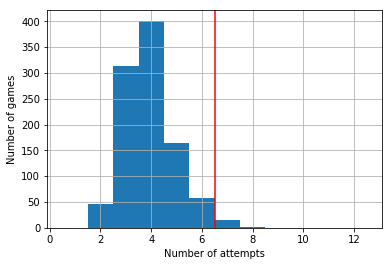

In [48]:
plt.hist(benchm1, bins=12, range=(0.5, 12.5))
plt.xlabel('Number of attempts')
plt.ylabel('Number of games')
plt.axvline(6.5, color='red')
plt.grid()
plt.show()

The above histogram shows the distribution of the number of attempts needed to guess the hidden word. We can already see that in most of the games we simulated, we needed less than 6 attempts.

In [49]:
# Median number of attempts
np.median(benchm1)

4.0

In [50]:
# Percentage of games in which the hidden word was found
(np.array(benchm1) <= 6).mean()

0.982

Both the median and the percentage of simulated games in which the hidden word was found show that simply picking randomly from the remaining words (and choosing a strong first word) is already a good strategy.

## 5.2. Choose from remaining words by score <a id='algo_score'>

Now we can try to tweak the first attempt by not choosing words randomly but taking into account the word score which represents how frequently the letters in a word occur in English words.

In [34]:
def suggest_next_by_score(prior_guesses, prior_res):
    """
    suggest_next_by_score suggests a next guess by choosing the word with the highest
    word score from the list of remaining words

    :prior_guesses: list of 5-character strings representing previous guesses
    :prior_res: list of feedback strings for previous guesses (in the same order as prior_guesses)
    :return: suggested next guess (string)
    """  
    suggest = remaining_words(prior_guesses, prior_res)
    suggest['score'] = suggest['word'].map(word_score)
    return suggest.sort_values('score', ascending=False).iloc[0,0]

Here is an example:

In [35]:
suggest_next_by_score(prior_guesses = ['irate','scree'],
                      prior_res     = ['xyxxg','yxgyg'])

'verse'

(`verse` is actually the hidden word here used to generate the example responses.)

### Quantifying performance

We'll quantify the performance again by simulating a number of Wordle games. In addition, we can now compare the performance to that of the previous method (random selection).

In [36]:
benchm2 = benchmark_method(guessing_function = suggest_next_by_score, n_samples = 1000)

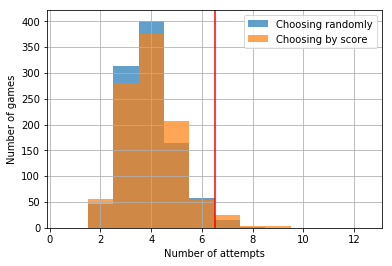

In [51]:
plt.hist(benchm1, bins=12, range=(0.5, 12.5), label='Choosing randomly', alpha=0.7)
plt.hist(benchm2, bins=12, range=(0.5, 12.5), label='Choosing by score', alpha=0.7)
plt.xlabel('Number of attempts')
plt.ylabel('Number of games')
plt.axvline(6.5, color='red')
plt.grid()
plt.legend()
plt.show()

The above histogram shows the distribution of the number of attempts needed to guess the hidden word. We can already see that in most of the games we simulated, we needed less than 6 attempts.

In [52]:
# Median number of attempts
np.median(benchm2)

4.0

In [53]:
# Percentage of games in which the hidden word was found
(np.array(benchm2) <= 6).mean()

0.97

There is no substantial improvement to the overall result, probably because excluding letters only helps in the first 1 or 2 guesses after which there is enough information to sufficiently narrow down the list of remaining words.